In [ ]:
%pip install nltk --upgrade

In [88]:
import pandas as pd
import requests
from pprint import pprint
import datetime
from IPython.display import clear_output
import time

In [89]:
# define which game to scrape
#appid = 24780  # simcity4
appid = 2357570 # over watch 2

# set base name for the file
#base_name = 'simcity4'
base_name = 'overwatch2'

scrape_file = f'reviews_{base_name}.csv'
results_file = f'results_{base_name}.csv'
extended_file = f'reviews_{base_name}_extended.csv'

In [ ]:
# Open a file to write the scraped data
with open(scrape_file, "w+", encoding='utf-8') as fo:
    # Write the header for the CSV file
    print("review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review", file=fo)

    cursor = '*'  # Start with the initial cursor
    base_url = f'https://store.steampowered.com/appreviews/{appid}'

    curr_page = 0 # Initialize the current page counter
    while True:
        # Set the parameters for the API request
        params = { # https://partner.steamgames.com/doc/store/getreviews
            'json' : 1,
            'filter' : 'all', # sort by: recent, updated, all (helpfulness)
            'language' : 'english', # https://partner.steamgames.com/doc/store/localization # Only fetch reviews in English
            'day_range' : 9223372036854775807, # shows reviews from all time 
            'review_type' : 'all', # include all reviews (positive and negative)
            'purchase_type' : 'all', # all, non_steam_purchase, steam
            'num_per_page' : 100, # Number of reviews per page
            'cursor': cursor,  # Use the cursor returned from the last request
        }
        response = requests.get(base_url, params=params) #Make the API request
        data = response.json() # Parse the JSON response

        print(curr_page, end=" ") # Print the current page number
        curr_page += 1 # Increment the current page counter

        # Break the loop if there are no more reviews
        if 'reviews' in data and not data['reviews']:
            break
        
        page_list = data['reviews'] # Get the list of reviews from the response

        for i, page in enumerate(page_list):
            words =  page["review"].split() # Split the review text into words

            if len(words) < 30: 
                continue # Skip reviews with less than 30 words
            
            # Prepare the review text for CSV
            rev = '"' + page["review"].replace('"',"") + '"'
            author_vote = 1 if page['voted_up'] else 0 # Convert voted_up to binary
            other_votes = page['votes_up']
            weighted_vote_score = page["weighted_vote_score"] 
            votes_funny = page["votes_funny"] # Get votes_funny or default to 0
            comment_count = page["comment_count"] # Get comment_count or default to 0
            timestamp_created = datetime.datetime.fromtimestamp(page["timestamp_created"]).strftime('%Y-%m-%d %H:%M:%S') # Convert timestamp to human-readable format
            playtime_at_review = page["author"].get("playtime_at_review", 0) #Get playtime_at_review or default to 0

            # Write the extracted data to the CSV file
            print(rev, ',', author_vote, ',', other_votes, ',', weighted_vote_score, ',', votes_funny, ',', comment_count, ',', timestamp_created, ',', playtime_at_review, file=fo)

        # Update the cursor for the next API request
        cursor = data['cursor']

In [90]:
# Using the SentiWordNet lexicon
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pandas as pd

# Download the SentiWordNet and WordNet resources
nltk.download('sentiwordnet');
nltk.download('wordnet');
nltk.download('averaged_perceptron_tagger');
nltk.download('punkt');

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\charding\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\charding\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\charding\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\charding\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [91]:
def get_sentiment(word, pos):
    synsets = list(swn.senti_synsets(word, pos))
    if not synsets:
        return 0, 0, 0
    synset = synsets[0]
    return synset.pos_score(), synset.neg_score(), synset.obj_score()

def sentiment_analysis_SentiWordNet(sentence):
    tokens = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    sentiment_scores = {'positive': 0, 'negative': 0, 'objective': 0 }
    word_count = 0
    adj_count = 0
    verb_count = 0
    noun_count = 0
    adv_count = 0

    for word, tag in pos_tags:
        wn_tag = get_wordnet_pos(tag)

        if wn_tag is not None:
            #print(f"{word}={wn_tag}", end=", ")
            pos_score, neg_score, obj_score = get_sentiment(word, wn_tag)
            sentiment_scores['positive'] += pos_score
            sentiment_scores['negative'] += neg_score
            sentiment_scores['objective'] += obj_score
            word_count += 1
            # CH: you need to only count for adjectives, verbs, nouns, and adverbs
            # if wn_tag is of that type !
            if wn_tag == wn.ADJ:
                adj_count += 1
            if wn_tag == wn.VERB:
                verb_count += 1 
            if wn_tag == wn.NOUN:
                noun_count += 1
            if wn_tag == wn.ADV:
                adv_count += 1

    # Normalize the score by the number of words
    if word_count > 0:
        sentiment_scores['positive'] /= word_count
        sentiment_scores['negative'] /= word_count
        sentiment_scores['objective'] /= word_count
    return sentiment_scores['positive'], sentiment_scores['negative'], sentiment_scores['objective'], word_count, adj_count, verb_count, noun_count, adv_count

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

In [23]:
# Read the scraped CSV file
df = pd.read_csv(scrape_file, encoding='utf-8'  )
print(len(df), "reviews loaded")
display(df)

19081 reviews loaded


,review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review
0,"Alright, let's actually provide a constructive...",0,11171,0.980039,205,0,2023-08-21 13:16:50,17
1,"Alright, let's actually provide a constructive...",0,7899,0.972536,130,88,2024-01-27 00:05:18,7
2,"Alright, let's actually provide a constructive...",0,4954,0.971620,76,88,2023-12-26 23:22:02,13
3,Imagine you bought a book and its great.\r\nfe...,0,3230,0.970043,194,0,2024-02-08 13:39:54,2772
4,[i][b]What we’re hoping to do with Overwatch 2...,0,1189,0.966396,27,58,2023-08-10 14:14:46,17
...,...,...,...,...,...,...,...,...
19076,[h1]Textbook example about how to screw up you...,0,1,0.000000,0,0,2023-08-10 13:59:43,8
19077,i am addicted :( help me help me help me help ...,0,0,0.000000,0,0,2023-08-10 13:58:57,2530
19078,Piece of trash of a game with imbecile develop...,0,0,0.000000,0,0,2023-08-10 13:58:07,5
19079,I was happy to see PvE as it was the only thin...,0,0,0.000000,0,0,2023-08-10 13:57:34,8


In [24]:
# Perform sentiment analysis on each review
# if there is already a results file, skip this and create
# an extended file in the next next cell
results = []

reviews = df['review'].tolist()

for i, review in enumerate(reviews):
    pos_score, neg_score, obj_score, word_count, adj_count, verb_count, noun_count, adv_count = sentiment_analysis_SentiWordNet(review)
    results.append({
        #'review': review, # CH no need for the reviews after this stage
        'positive_score': round(pos_score, 3),
        'negative_score': round(neg_score, 3),
        'objective_score': round(obj_score, 3),
        'word_count': word_count,
        'adj_count': adj_count,
        'verb_count': verb_count,
        'noun_count': noun_count,
        'adv_count': adv_count,
    })
    if i % 100 == 0:
        print(i, end=" ")
    
# Convert the results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Save the results to a CSV file incase the concat does not work
results_df.to_csv(results_file, index=False)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

In [25]:
# Perform descriptive statistics, using the describe() method from pandas to compute descriptive statistics (mean, standard deviation, min, max, etc.) for the sentiment scores and word count.
#descriptive_stats = results_df.describe()
#print(descriptive_stats)

# Perform descriptive statistics on the combined DataFrame
#descriptive_stats = combined_df.describe(include='all')
#print(descriptive_stats)

# read in file so it's independent from the previous cells
results_df = pd.read_csv(results_file)

# Combine the original DataFrame with the sentiment analysis results
combined_df = pd.concat([df, results_df], axis=1)

# Print the combined DataFrame
# print(combined_df)

# Perform descriptive statistics on the combined DataFrame
# descriptive_stats = combined_df.describe(include='all')
# print(descriptive_stats)

In [26]:
display(combined_df)

,review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review,positive_score,negative_score,objective_score,word_count,adj_count,verb_count,noun_count,adv_count
0,"Alright, let's actually provide a constructive...",0,11171,0.980039,205,0,2023-08-21 13:16:50,17,0.066,0.046,0.749,815,119,271,334,91
1,"Alright, let's actually provide a constructive...",0,7899,0.972536,130,88,2024-01-27 00:05:18,7,0.066,0.046,0.749,815,119,271,334,91
2,"Alright, let's actually provide a constructive...",0,4954,0.971620,76,88,2023-12-26 23:22:02,13,0.066,0.046,0.749,815,119,271,334,91
3,Imagine you bought a book and its great.\r\nfe...,0,3230,0.970043,194,0,2024-02-08 13:39:54,2772,0.061,0.023,0.826,33,7,11,10,5
4,[i][b]What we’re hoping to do with Overwatch 2...,0,1189,0.966396,27,58,2023-08-10 14:14:46,17,0.058,0.029,0.525,466,60,100,262,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19076,[h1]Textbook example about how to screw up you...,0,1,0.000000,0,0,2023-08-10 13:59:43,8,0.046,0.035,0.515,114,21,30,54,9
19077,i am addicted :( help me help me help me help ...,0,0,0.000000,0,0,2023-08-10 13:58:57,2530,0.005,0.002,0.993,51,0,50,1,0
19078,Piece of trash of a game with imbecile develop...,0,0,0.000000,0,0,2023-08-10 13:58:07,5,0.112,0.033,0.855,19,2,5,10,2
19079,I was happy to see PvE as it was the only thin...,0,0,0.000000,0,0,2023-08-10 13:57:34,8,0.151,0.023,0.589,38,6,15,16,1


In [27]:
# write combined data to a new file
# this is so we can load the data back in later without having to re-compute the sentiment analysis
combined_df.to_csv(extended_file, index=False, encoding='utf-8')

In [92]:
# Load the CSV file'
df = pd.read_csv(extended_file)

# make sure we don't have duplicate reviews so drop rows where positive_score, negative_score, objective_score 
# are the same
df = df.drop_duplicates(subset=['positive_score', 'negative_score', 'objective_score'])

# re-index the dataframe
df = df.reset_index(drop=True)

print(len(df), "unique reviews loaded")

# Display basic information about the dataset
print(df.info())

18007 unique reviews loaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18007 entries, 0 to 18006
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   review               18007 non-null  object 
 1   author_vote          18007 non-null  int64  
 2   other_votes          18007 non-null  int64  
 3   weighted_vote_score  18007 non-null  float64
 4   votes_funny          18007 non-null  int64  
 5   comment_count        18007 non-null  int64  
 6   timestamp_created    18007 non-null  object 
 7   playtime_at_review   18007 non-null  int64  
 8   positive_score       18007 non-null  float64
 9   negative_score       18007 non-null  float64
 10  objective_score      18007 non-null  float64
 11  word_count           18007 non-null  int64  
 12  adj_count            18007 non-null  int64  
 13  verb_count           18007 non-null  int64  
 14  noun_count           18007 non-null  int64  
 15  adv_coun

In [31]:
# Display the first few rows of the dataset
display(df.head())

,review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review,positive_score,negative_score,objective_score,word_count,adj_count,verb_count,noun_count,adv_count
0,"Alright, let's actually provide a constructive...",0,11171,0.980039,205,0,2023-08-21 13:16:50,17,0.066,0.046,0.749,815,119,271,334,91
3,Imagine you bought a book and its great.\r\nfe...,0,3230,0.970043,194,0,2024-02-08 13:39:54,2772,0.061,0.023,0.826,33,7,11,10,5
4,[i][b]What we’re hoping to do with Overwatch 2...,0,1189,0.966396,27,58,2023-08-10 14:14:46,17,0.058,0.029,0.525,466,60,100,262,44
5,Team Fortress 2\r\nPortal 2\r\nBatman Arkham A...,0,19324,0.966062,743,0,2023-08-10 15:37:12,30,0.025,0.038,0.624,160,8,11,135,6
6,"I cried at the part when Reaper said BUY, BUY,...",0,11569,0.965763,2961,0,2023-08-11 17:16:30,106,0.138,0.006,0.706,20,1,5,14,0


In [35]:
# Display summary statistics of numeric data in the dataset
# CH note that all reviews now are listed as unique i.e. no duplicates
display(df.describe(include='all'))

,review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review,positive_score,negative_score,objective_score,word_count,adj_count,verb_count,noun_count,adv_count
count,18007,18007.000000,18007.000000,18007.000000,18007.000000,18007.000000,18007,18007.000000,18007.000000,18007.000000,18007.000000,18007.000000,18007.000000,18007.000000,18007.000000,18007.000000
unique,18007,NaN,NaN,NaN,NaN,NaN,17891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,"Alright, let's actually provide a constructive...",NaN,NaN,NaN,NaN,NaN,2023-08-13 13:46:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.207364,15.335758,0.327360,1.745099,0.247126,NaN,1655.910424,0.071396,0.055636,0.681922,85.793080,11.271228,25.856112,38.246015,10.419726
std,NaN,0.405430,329.864645,0.253523,40.773188,3.895875,NaN,5090.197786,0.031837,0.030182,0.126606,116.971292,16.456874,36.846039,58.710381,14.759217
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,5.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,21.000000,0.051000,0.037000,0.651000,28.000000,3.000000,8.000000,12.000000,3.000000
50%,NaN,0.000000,1.000000,0.488398,0.000000,0.000000,NaN,112.000000,0.071000,0.053000,0.706000,45.000000,6.000000,14.000000,20.000000,6.000000
75%,NaN,0.000000,2.000000,0.523810,0.000000,0.000000,NaN,743.500000,0.090000,0.071000,0.750000,89.000000,12.000000,28.000000,39.000000,12.000000


In [36]:
# Check for missing values
print(df.isnull().sum())

review                 0
author_vote            0
other_votes            0
weighted_vote_score    0
votes_funny            0
comment_count          0
timestamp_created      0
playtime_at_review     0
positive_score         0
negative_score         0
objective_score        0
word_count             0
adj_count              0
verb_count             0
noun_count             0
adv_count              0
dtype: int64


In [93]:
# CH print out the timespan of the reviews
# this is useful for dweciding what timespand to aggregate to
print(df['timestamp_created'].min(), df['timestamp_created'].max())

 2023-08-10 13:52:00   2024-07-05 13:00:08 


In [94]:
# CH aggregate means of values over time (monthly)
df_agg  = df.copy() 
df_agg['timestamp_created'] = pd.to_datetime(df_agg['timestamp_created']) # make python datetime object
df_agg.set_index('timestamp_created', inplace=True) # set index to timestamp_created

# drop review column as it is not numeric
df_agg.drop(columns=['review'], inplace=True)

# resample all numeric columns to monthly
df_agg = df_agg.resample('MS').mean() # resample all numeric columns to monthly

# resample all numeric columns to 3 month
#df_agg = df_agg.resample('3MS').mean() # resample all numeric columns to 6 month

# resample all numeric columns to 6 month
#df_agg = df_agg.resample('6MS').mean() # resample all numeric columns to 6 month

df_agg.reset_index(inplace=True) # reset index to make timestamp_created a column again
df_agg['timestamp_created'] = df_agg['timestamp_created'].dt.strftime('%Y-%m') # format timestamp_created
display(df_agg)



,timestamp_created,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,playtime_at_review,positive_score,negative_score,objective_score,word_count,adj_count,verb_count,noun_count,adv_count
0,2023-08,0.175580,18.540763,0.333851,1.814697,0.283844,413.460826,0.070949,0.053980,0.676262,94.797027,12.525243,28.578254,42.187734,11.505797
1,2023-09,0.191894,17.110835,0.349146,2.668321,0.327543,1590.737800,0.071264,0.056682,0.685561,85.537634,11.181969,25.541770,38.553350,10.260546
2,2023-10,0.245940,11.944316,0.357477,2.012761,0.325986,2267.294664,0.073041,0.057393,0.689107,78.444316,9.998840,24.053364,35.053364,9.338747
3,2023-11,0.350000,10.054878,0.305742,1.017073,0.206098,3180.254878,0.076513,0.054895,0.687716,66.174390,8.902439,20.462195,28.490244,8.319512
4,2023-12,0.271812,9.595638,0.366003,0.657718,0.203020,3141.098993,0.072720,0.057364,0.689361,69.684564,9.177852,20.902685,30.736577,8.867450
5,2024-01,0.259786,4.457295,0.290049,0.384342,0.151246,3873.532028,0.073338,0.059233,0.682119,69.270463,8.943060,20.734875,31.085409,8.507117
6,2024-02,0.269461,6.970060,0.295766,0.598802,0.059880,3989.001497,0.071768,0.059006,0.695349,69.739521,8.922156,21.305389,30.750000,8.761976
7,2024-03,0.268836,10.854452,0.296443,1.150685,0.082192,3573.618151,0.073168,0.059625,0.692293,70.523973,8.912671,21.426370,31.717466,8.467466
8,2024-04,0.262295,12.678092,0.322845,4.746647,0.154993,5061.068554,0.070487,0.058820,0.694970,66.196721,8.160954,18.837556,31.482861,7.715350
9,2024-05,0.239938,11.349845,0.275182,0.897833,0.128483,4974.950464,0.069743,0.059217,0.690972,72.134675,9.489164,22.128483,31.503096,9.013932


In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_over_time(columns, df, logy=False):
    df = df[columns + ['timestamp_created']]
    # Melting the DataFrame
    df_melted = df.melt('timestamp_created', var_name='variable', value_name='value')
    plt.figure(figsize=(20, 8))
    
    sns.lineplot(data=df_melted, x='timestamp_created', y='value', hue='variable')
    if logy:
        plt.yscale('log')

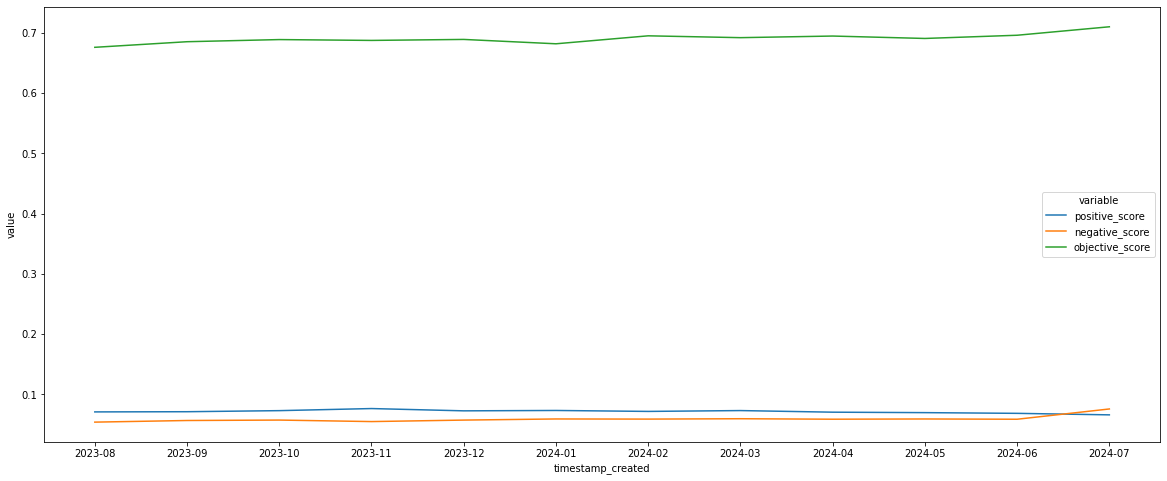

In [64]:
plot_over_time(['positive_score', 'negative_score', 'objective_score'], df_agg, logy=False)

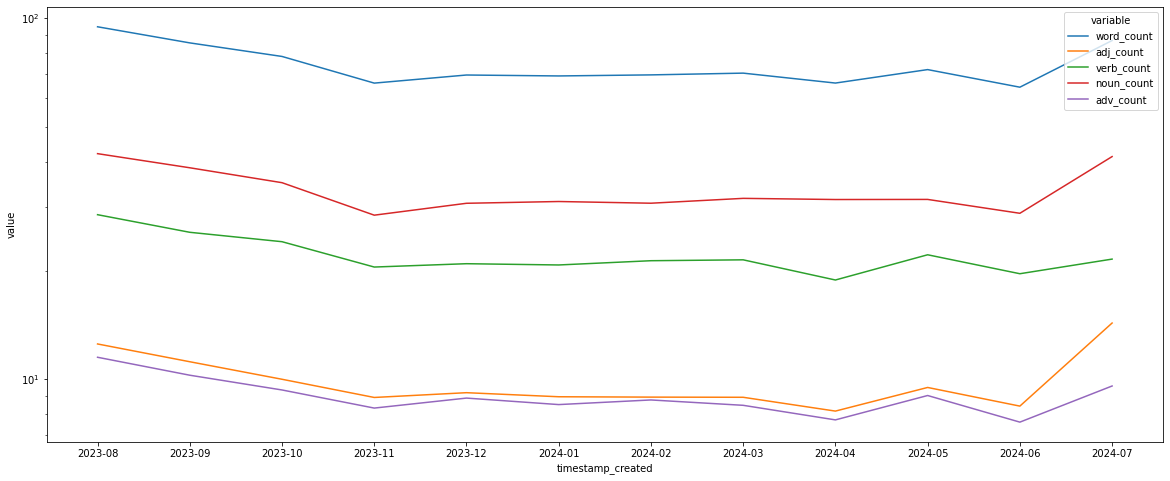

In [65]:
plot_over_time(['word_count', 'adj_count', 'verb_count', 'noun_count', 'adv_count'], df_agg, logy=True)

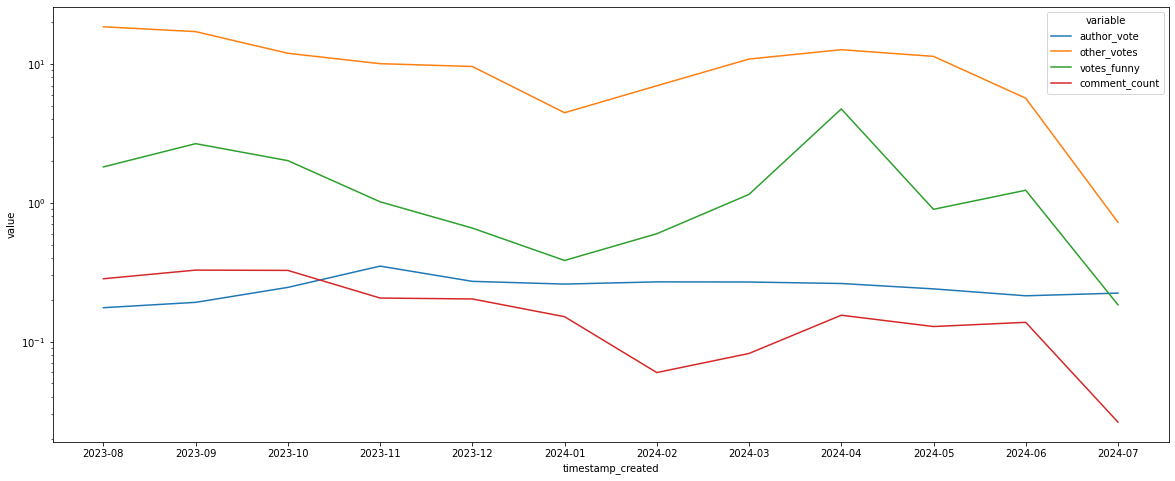

In [66]:
plot_over_time(['author_vote', 'other_votes', 'votes_funny', 'comment_count'], df_agg, logy=True)

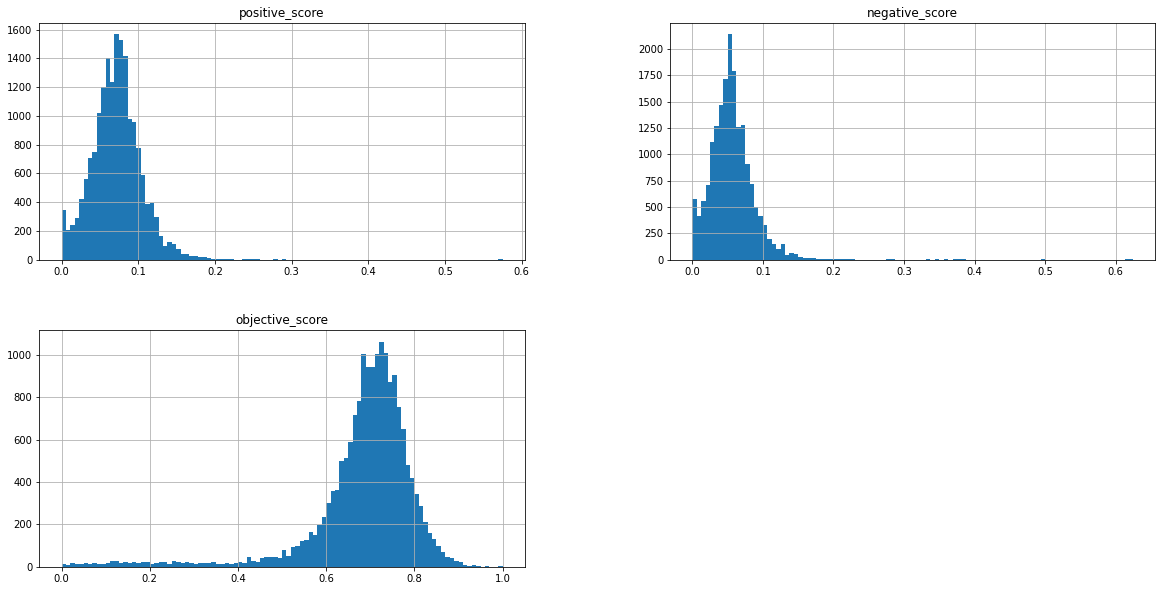

In [72]:
# Distribution of Numerical Variables
# Visualize the distribution of numerical variables using histograms and boxplots.
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for numerical columns

dfs = df[['positive_score', 'negative_score', 'objective_score']]
dfs.hist(bins=100, figsize=(20, 10))
plt.show()

# Boxplot for numerical columns
#plt.figure(figsize=(15, 10))
#sns.boxplot(data=df)
#plt.xticks(rotation=90)
#plt.show()

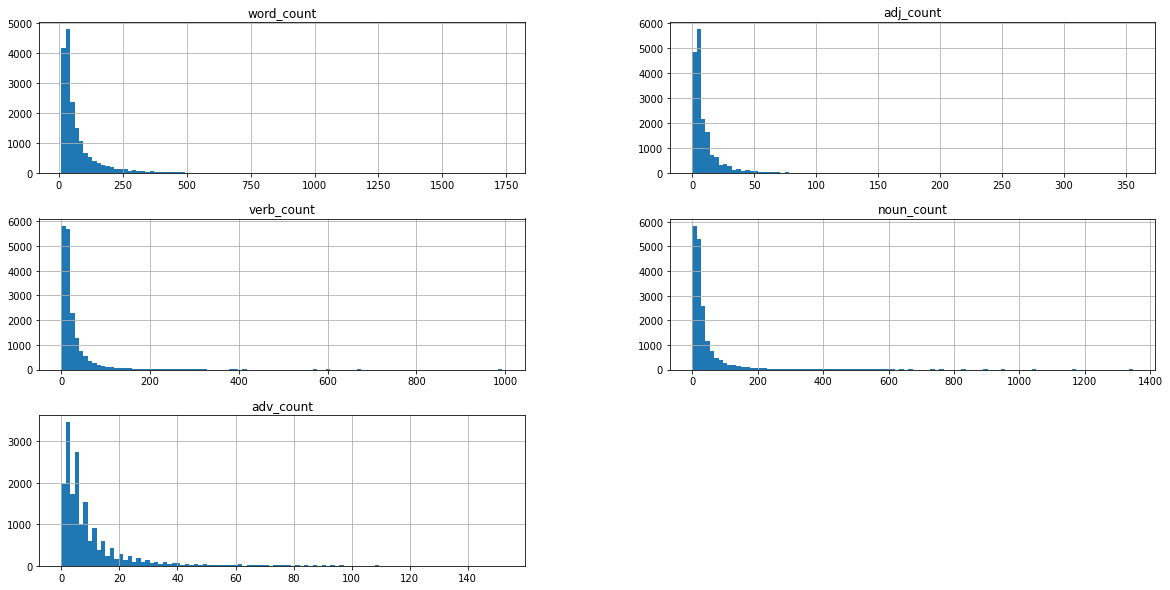

In [75]:
dfc = df[['word_count', 'adj_count', 'verb_count', 'noun_count', 'adv_count']]
axes = dfc.hist(bins=100, figsize=(20, 10))
# set all x-axis to log scale
#for ax in axes.flatten():
#    ax.set_xscale('log')


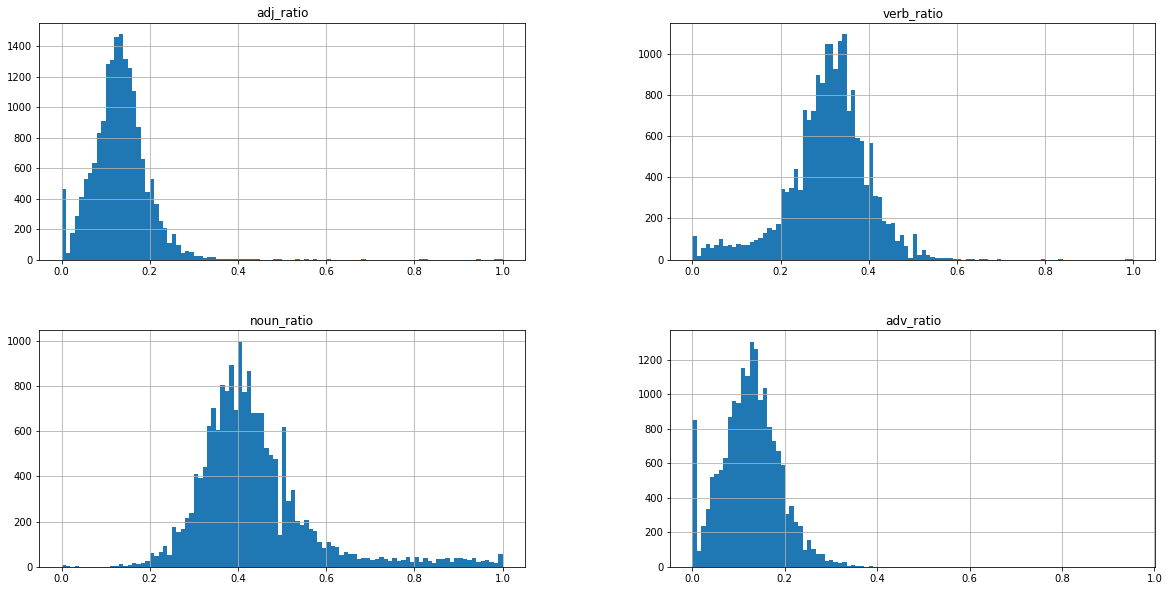

In [77]:
# add columns to df that describe the ratio of adj, verb, noun, adv to word count
df['adj_ratio'] = df['adj_count'] / df['word_count']
df['verb_ratio'] = df['verb_count'] / df['word_count']
df['noun_ratio'] = df['noun_count'] / df['word_count']
df['adv_ratio'] = df['adv_count'] / df['word_count']

dfr = df[['adj_ratio', 'verb_ratio', 'noun_ratio', 'adv_ratio']]
axes = dfr.hist(bins=100, figsize=(20, 10))


<Axes: xlabel='POS_ratio'>

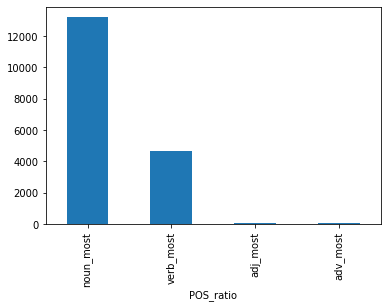

In [82]:
# to df add a column that indicates which of adj, verb, noun, adv is the biggest 
# encode with "adj_count", "verb_count", "noun_count", "adv_count"
df['POS_ratio'] = df[['adj_ratio', 'verb_ratio', 'noun_ratio', 'adv_ratio']].idxmax(axis=1)

# in df['POS_ratio'] rename adj_ratio to adj_most, verb_ratio to verb_most, noun_ratio to noun_most, adv_ratio to adv_most
df['POS_ratio'] = df['POS_ratio'].replace({'adj_ratio': 'adj_most', 'verb_ratio': 'verb_most', 'noun_ratio': 'noun_most', 'adv_ratio': 'adv_most'})

# show the distribution of the POS_ratio
df['POS_ratio'].value_counts().plot(kind='bar');

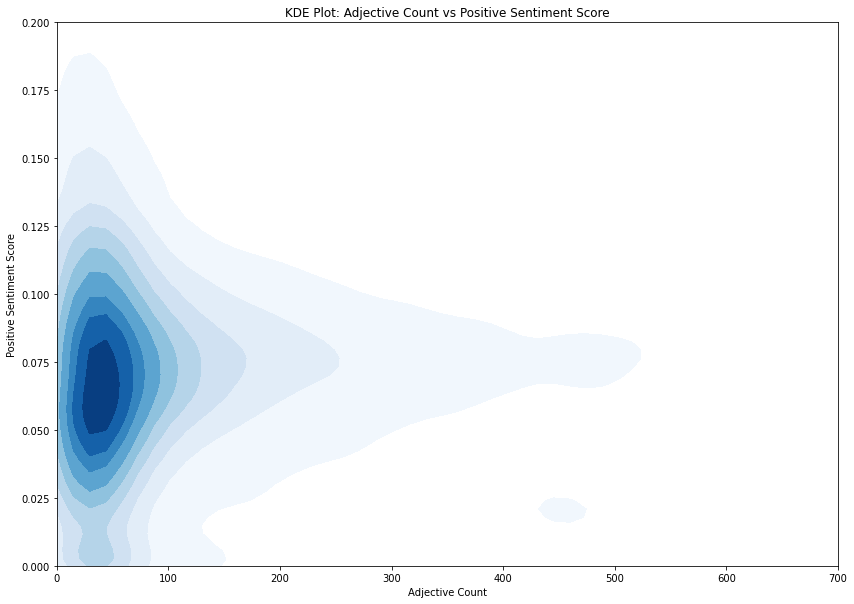

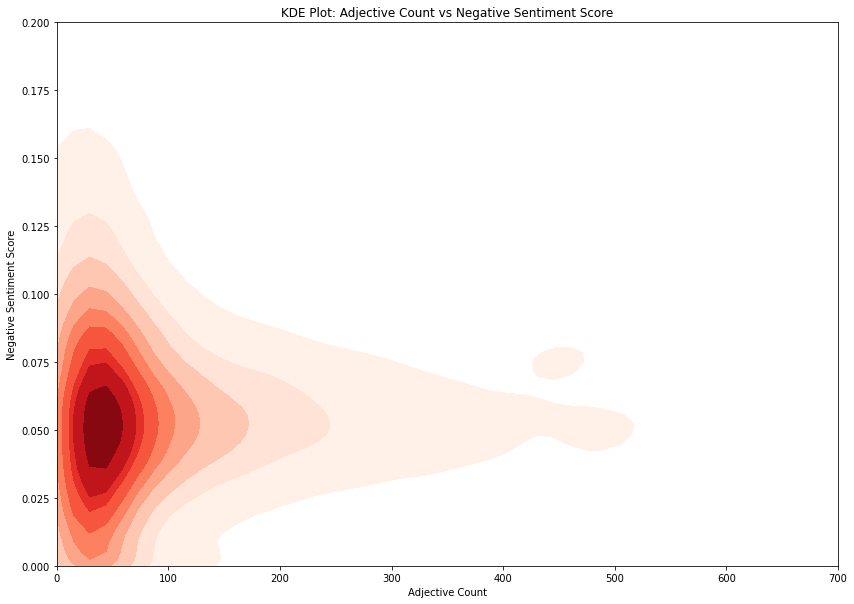

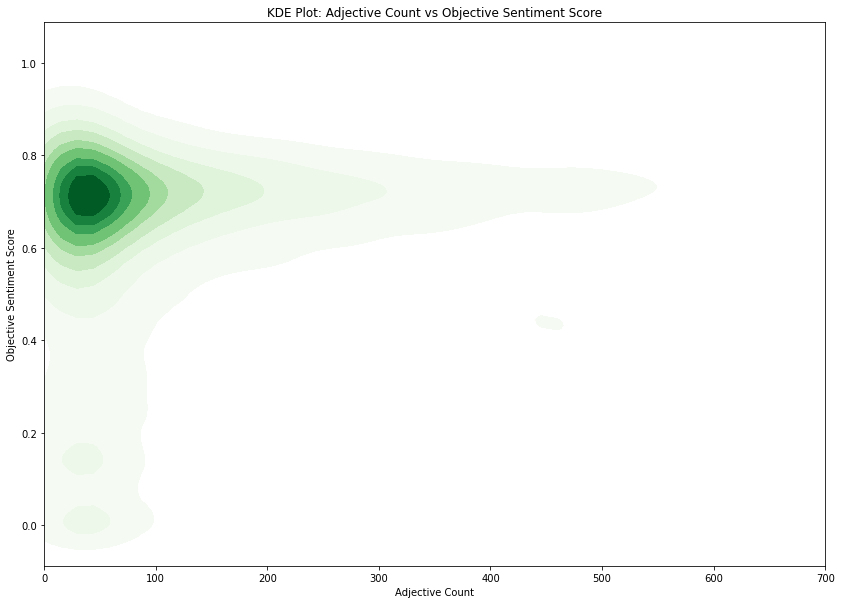

In [86]:
# Plotting KDE plots
plt.figure(figsize=(14, 10))

# KDE plot for positive sentiment score vs adjective count
sns.kdeplot(data=results_df, x='word_count', y='positive_score', fill=True, cmap="Blues", thresh=0.05)
plt.title('KDE Plot: Adjective Count vs Positive Sentiment Score')
plt.xlabel('Adjective Count')
plt.ylabel('Positive Sentiment Score')
plt.xlim(0, 600) # limit x-axis to 0-600
plt.ylim(0, 0.2)
plt.show()

# KDE plot for negative sentiment score vs adjective count
plt.figure(figsize=(14, 10))
sns.kdeplot(data=results_df, x='word_count', y='negative_score', fill=True, cmap="Reds", thresh=0.05)
plt.title('KDE Plot: Adjective Count vs Negative Sentiment Score')
plt.xlabel('Adjective Count')
plt.ylabel('Negative Sentiment Score')
plt.xlim(0, 600)
plt.ylim(0, 0.2)
plt.show()

# KDE plot for objective sentiment score vs adjective count
plt.figure(figsize=(14, 10))
sns.kdeplot(data=results_df, x='word_count', y='objective_score', fill=True, cmap="Greens", thresh=0.05)
plt.title('KDE Plot: Adjective Count vs Objective Sentiment Score')
plt.xlabel('Adjective Count')
plt.ylabel('Objective Sentiment Score')
plt.xlim(0, 700)
plt.show()

NameError: name 'r2' is not defined

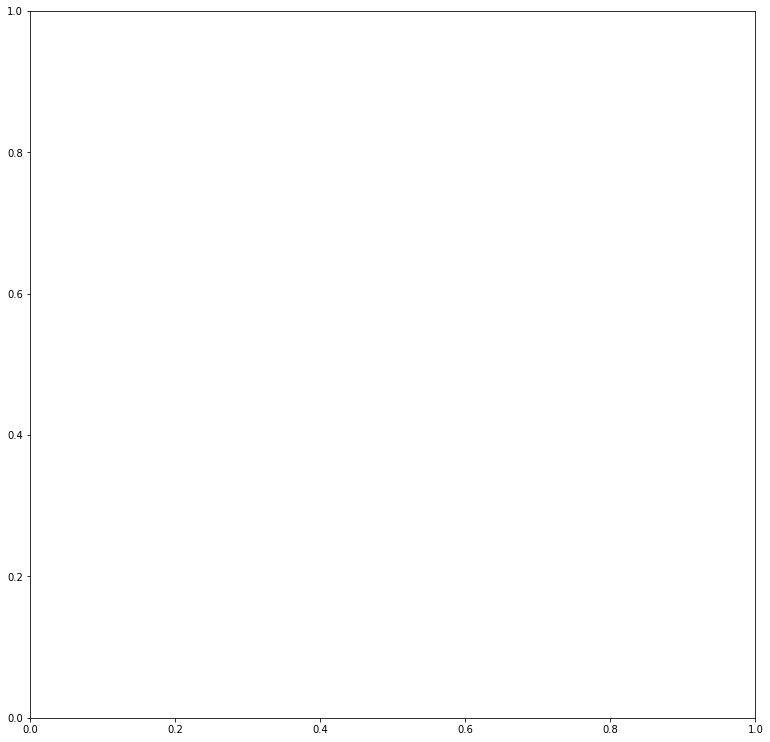

In [87]:
# next step: correlation matrix between all values. However, first I need to get the R2s.
ax1, fig =  plt.subplots(figsize= (13, 13))
sns.heatmap(abs(r2), 
            annot = True, 
            fmt=".1f"); # show numbers, but with 1 digit only